# Задача 2. Обучение без учителя

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


# Dataset Description

**Context**:
PLUTO is a master record of the locations and characteristics of buildings in New York City. It’s published by the New York City Department of City Planning on an approximately quarterly-to-half-yearly basis, and is one of the more important datasets for civic analysis in New York City.

**Content**:
PLUTO includes information on building height, square footage, location, type, landmark status, number of units, owner, year of construction, and other related fields.

**Acknowledgements**:
This dataset is published as-is by the New York City Department of Planning.

**Inspiration**:
Can you define neighborhoods by clustering similar buildings within them?

Link: https://www.kaggle.com/datasets/new-york-city/nyc-buildings?select=MN.csv

# Preparations

Merge dataset files into a single one to easier access

In [197]:
import pandas as pd

is_merged = True
if is_merged:
    df = pd.read_csv('../../data/new_york_buildings/merged_data.csv')
else:
    datasets = ['../../data/new_york_buildings/BK.csv', '../../data/new_york_buildings/BX.csv', '../../data/new_york_buildings/MN.csv', '../../data/new_york_buildings/QN.csv', '../../data/new_york_buildings/SI.csv']
    
    all_dfs = [pd.read_csv(f)[::10] for f in datasets]
    
    # Concatenate DataFrames
    df = pd.concat(all_dfs, ignore_index=True)
    # Save merged data to a new CSV file (optional)
    df.to_csv("../../data/new_york_buildings/merged_data.csv", index=False)

Merged dataset information

In [198]:
len(df['Borough']), df['Borough'].nunique()

(85839, 5)

# EDA (Exploratory Data Analysis)

## Imports

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

%precision % .4f

'% .4f'

## Preprocessing

### NaN Values

In [200]:
df = pd.read_csv('../../data/new_york_buildings/merged_data.csv')[::10]
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
10,BK,34,10,302,21.0,3012.0,13.0,33.0,11201.0,E207,...,195545.0,12d,NaN,302 009,30101.0,NaN,0.000000e+00,NaN,1,16V2
20,BK,45,115,302,21.0,1008.0,13.0,33.0,11201.0,E205,...,195068.0,12d,NaN,302 015,30101.0,E-89,3.000450e+09,7/11/2005,1,16V2
30,BK,110,25,302,23.0,3006.0,13.0,35.0,11201.0,L118,...,193595.0,12d,NaN,302 034,30102.0,NaN,0.000000e+00,NaN,1,16V2
40,BK,146,15,302,15.0,3007.0,13.0,33.0,11201.0,L110,...,191139.0,16c,NaN,302 024,30104.0,E-124,0.000000e+00,NaN,1,16V2


In [152]:
print('Count elements in dataset: ', len(df))

Count elements in dataset:  10730


In [201]:
is_null_stat = pd.DataFrame()
is_null_stat['is_null'] = df.isna().sum()
is_null_stat['all'] = len(df)
is_null_stat['percent'] = is_null_stat['is_null'] / is_null_stat['all'] * 100

ok_stat = is_null_stat[is_null_stat['percent'] <= 55] # Remove features that have >= 55% NaN
ok_stat

,is_null,all,percent
Borough,0,8584,0.000000
Block,0,8584,0.000000
Lot,0,8584,0.000000
CD,0,8584,0.000000
CT2010,48,8584,0.559180
...,...,...,...
Sanborn,8,8584,0.093197
TaxMap,8,8584,0.093197
APPBBL,8,8584,0.093197
PLUTOMapID,0,8584,0.000000


In [202]:
cols = ok_stat.index
df = df[cols]

In [203]:
df.head(100)

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,Sanborn,TaxMap,APPBBL,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,0,21,NaN,NaN,12d,302 007,30101.0,3.000010e+09,1,16V2
10,BK,34,10,302,21.0,3012.0,13.0,33.0,11201.0,E207,...,0,21,989657.0,195545.0,12d,302 009,30101.0,0.000000e+00,1,16V2
20,BK,45,115,302,21.0,1008.0,13.0,33.0,11201.0,E205,...,0,21,986945.0,195068.0,12d,302 015,30101.0,3.000450e+09,1,16V2
30,BK,110,25,302,23.0,3006.0,13.0,35.0,11201.0,L118,...,0,23,989258.0,193595.0,12d,302 034,30102.0,0.000000e+00,1,16V2
40,BK,146,15,302,15.0,3007.0,13.0,33.0,11201.0,L110,...,0,15,988659.0,191139.0,16c,302 024,30104.0,0.000000e+00,1,16V2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,BK,585,22,306,53.0,1011.0,15.0,38.0,11231.0,L101,...,0,53,979940.0,186236.0,16a,301 002,30207.0,0.000000e+00,1,16V2
960,BK,587,53,306,53.0,3004.0,15.0,38.0,11231.0,L101,...,0,53,980452.0,185630.0,16a,301 019,30207.0,0.000000e+00,1,16V2
970,BK,597,35,306,53.0,3001.0,15.0,38.0,11231.0,L101,...,0,53,980033.0,185669.0,16a,301 019,30207.0,0.000000e+00,1,16V2
980,BK,604,4,306,53.0,NaN,15.0,38.0,11231.0,L101,...,0,53,NaN,NaN,16a,301 019,30207.0,0.000000e+00,1,16V2


Now we have to deal with features that have NaN, but their count is not so big

In [204]:
ok_stat[ok_stat['percent'] != 0]

,is_null,all,percent
CT2010,48,8584,0.559180
CB2010,225,8584,2.621156
SchoolDist,32,8584,0.372787
Council,32,8584,0.372787
ZipCode,49,8584,0.570829
FireComp,35,8584,0.407735
PolicePrct,30,8584,0.349487
HealthArea,37,8584,0.431034
SanitBoro,63,8584,0.733924
SanitDistrict,62,8584,0.722274


In [205]:
most = df.SanitBoro.value_counts()
df.SanitBoro.fillna(most.index[0], inplace=True)

In [206]:
def fill_with_block_mean(df, cols):
    for col in cols:
        df[col] = df.groupby('Block')[col].transform(lambda x: x.fillna(x.mean()))
    return df

df = fill_with_block_mean(df, ['XCoord', 'YCoord', 'CB2010'])

In [207]:
def fill_fst_most(df, fst, snd):
    df[snd] = df.groupby(fst)[snd].transform(lambda x: x.fillna(x.value_counts().index[0] if len(x.value_counts()) > 0 else np.NAN))
    return df

fill_fst_most(df, 'SanitBoro', 'SanitSub')
fill_fst_most(df, 'SanitBoro', 'SanitDistrict')
fill_fst_most(df, 'Block', 'OwnerName')

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,Sanborn,TaxMap,APPBBL,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,...,0,21,NaN,NaN,12d,302 007,30101.0,3.000010e+09,1,16V2
10,BK,34,10,302,21.0,3012.0,13.0,33.0,11201.0,E207,...,0,21,989657.0,195545.0,12d,302 009,30101.0,0.000000e+00,1,16V2
20,BK,45,115,302,21.0,1008.0,13.0,33.0,11201.0,E205,...,0,21,986945.0,195068.0,12d,302 015,30101.0,3.000450e+09,1,16V2
30,BK,110,25,302,23.0,3006.0,13.0,35.0,11201.0,L118,...,0,23,989258.0,193595.0,12d,302 034,30102.0,0.000000e+00,1,16V2
40,BK,146,15,302,15.0,3007.0,13.0,33.0,11201.0,L110,...,0,15,988659.0,191139.0,16c,302 024,30104.0,0.000000e+00,1,16V2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85790,SI,8036,56,503,248.0,3012.0,31.0,51.0,10307.0,L076,...,0,248,918309.0,127594.0,32d,505 527,53203.0,5.080360e+09,1,16V2
85800,SI,8040,33,503,248.0,3021.0,31.0,51.0,10307.0,L076,...,0,248,917564.0,126563.0,35a,505 527,53203.0,0.000000e+00,1,16V2
85810,SI,8042,102,503,248.0,2011.0,31.0,51.0,10307.0,L076,...,0,248,917378.0,126043.0,35a,505 523,53203.0,0.000000e+00,1,16V2
85820,SI,8045,33,503,248.0,2013.0,31.0,51.0,10307.0,L076,...,0,248,916299.0,125574.0,35a,505 524,53203.0,0.000000e+00,1,16V2


In [208]:
df[['Block', 'OwnerName']]

,Block,OwnerName
0,1,BROOKLYN BRIDGE PARK
10,34,BLASOF ARTHUR
20,45,EDWARDS LEONARD
30,110,MADISON SQUARE BOYS'C
40,146,227 DUFFIELD STREET C
...,...,...
85790,8036,NaN
85800,8040,JANICE PANSINI TRUST
85810,8042,JAMES J RIGNEY
85820,8045,"SPEZIO, STEVEN"


In [209]:
df = df.dropna(how='any')

In [210]:
len(df), df.isna().sum()

(8342,
 Borough       0
 Block         0
 Lot           0
 CD            0
 CT2010        0
              ..
 Sanborn       0
 TaxMap        0
 APPBBL        0
 PLUTOMapID    0
 Version       0
 Length: 68, dtype: int64)

In [211]:
df.reset_index(drop=True, inplace=True)

### Feature Analysis

In [212]:
borough_dict = {'BK': 0, 'BX': 1, 'MN': 2, 'QN': 3, 'SI': 4}
df.Borough = df.Borough.apply(lambda x: borough_dict[x])

In [213]:
df.dtypes[df.dtypes == 'object']

FireComp      object
SanitSub      object
Address       object
ZoneDist1     object
SplitZone     object
BldgClass     object
OwnerName     object
IrrLotCode    object
ZoneMap       object
Sanborn       object
Version       object
dtype: object

In [214]:
df['Version'].value_counts() # all the same => drop
df.drop(columns=['Version'], inplace=True)

list_col = ['FireComp', 'SanitSub', 'ZoneDist1', 'BldgClass', 'ZoneMap', 'Sanborn']
boolean_col = ['SplitZone', 'IrrLotCode']
string_col = ['Address', 'OwnerName']

Process binary feature

In [215]:
for col in boolean_col:
    df[col] = df[col].apply(lambda x: x == "Y")

df.rename(columns={"SplitZone": "SplitZoneTrue", "IrrLotCode": "IrrLotCodeTrue"}, inplace=True)

Process nominal feature

In [216]:
conv_dict = {}
for col in list_col:
    d = {c: i for i, c in enumerate(df[col].unique())}
    d_rev = {i: c for i, c in enumerate(df[col].unique())}
    conv_dict[col] = {'to': d, 'from': d_rev}
    df[col] = df[col].apply(lambda x: d[x])

In [217]:
str_df = pd.DataFrame()
str_df['Target'] = df['Borough']

In [218]:
def has_special_chars(text):
    import re
    return bool(re.search(r"[^\w\s]", text))


str_df['owner_name_length'] = df['OwnerName'].str.len()
str_df['owner_name_num_words'] = df['OwnerName'].str.split().str.len()
str_df['owner_name_is_uppercase'] = df['OwnerName'].str.isupper().astype(int)
str_df['owner_name_has_special_chars'] = df['OwnerName'].apply(has_special_chars).astype(int)

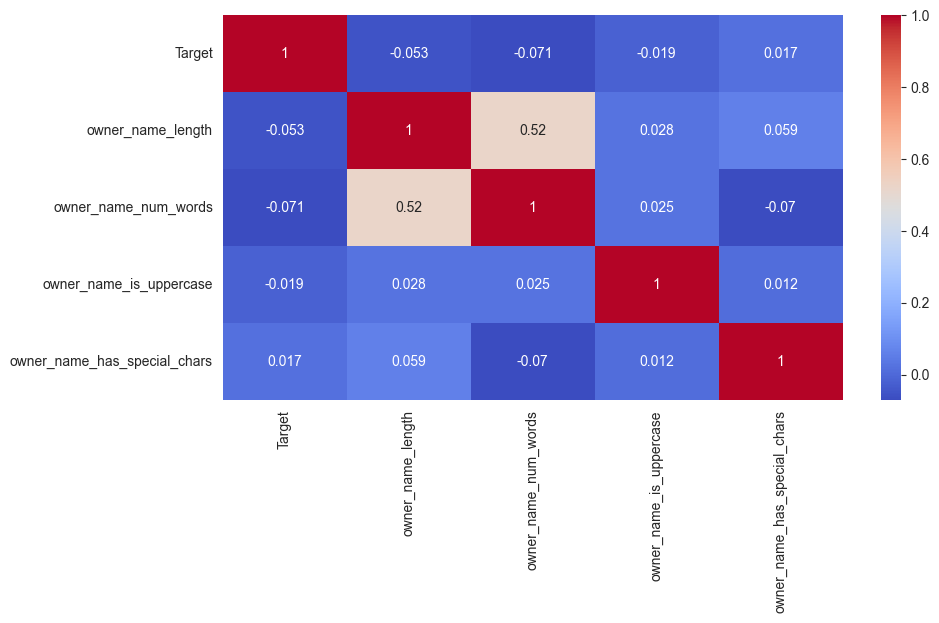

In [219]:
sns.heatmap(str_df.corr(), annot=True, cmap='coolwarm')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [220]:
df['OwnerNameLength'] = df['OwnerName'].str.len()

In [221]:
df.drop(['Address', 'OwnerName'], axis=1, inplace=True)

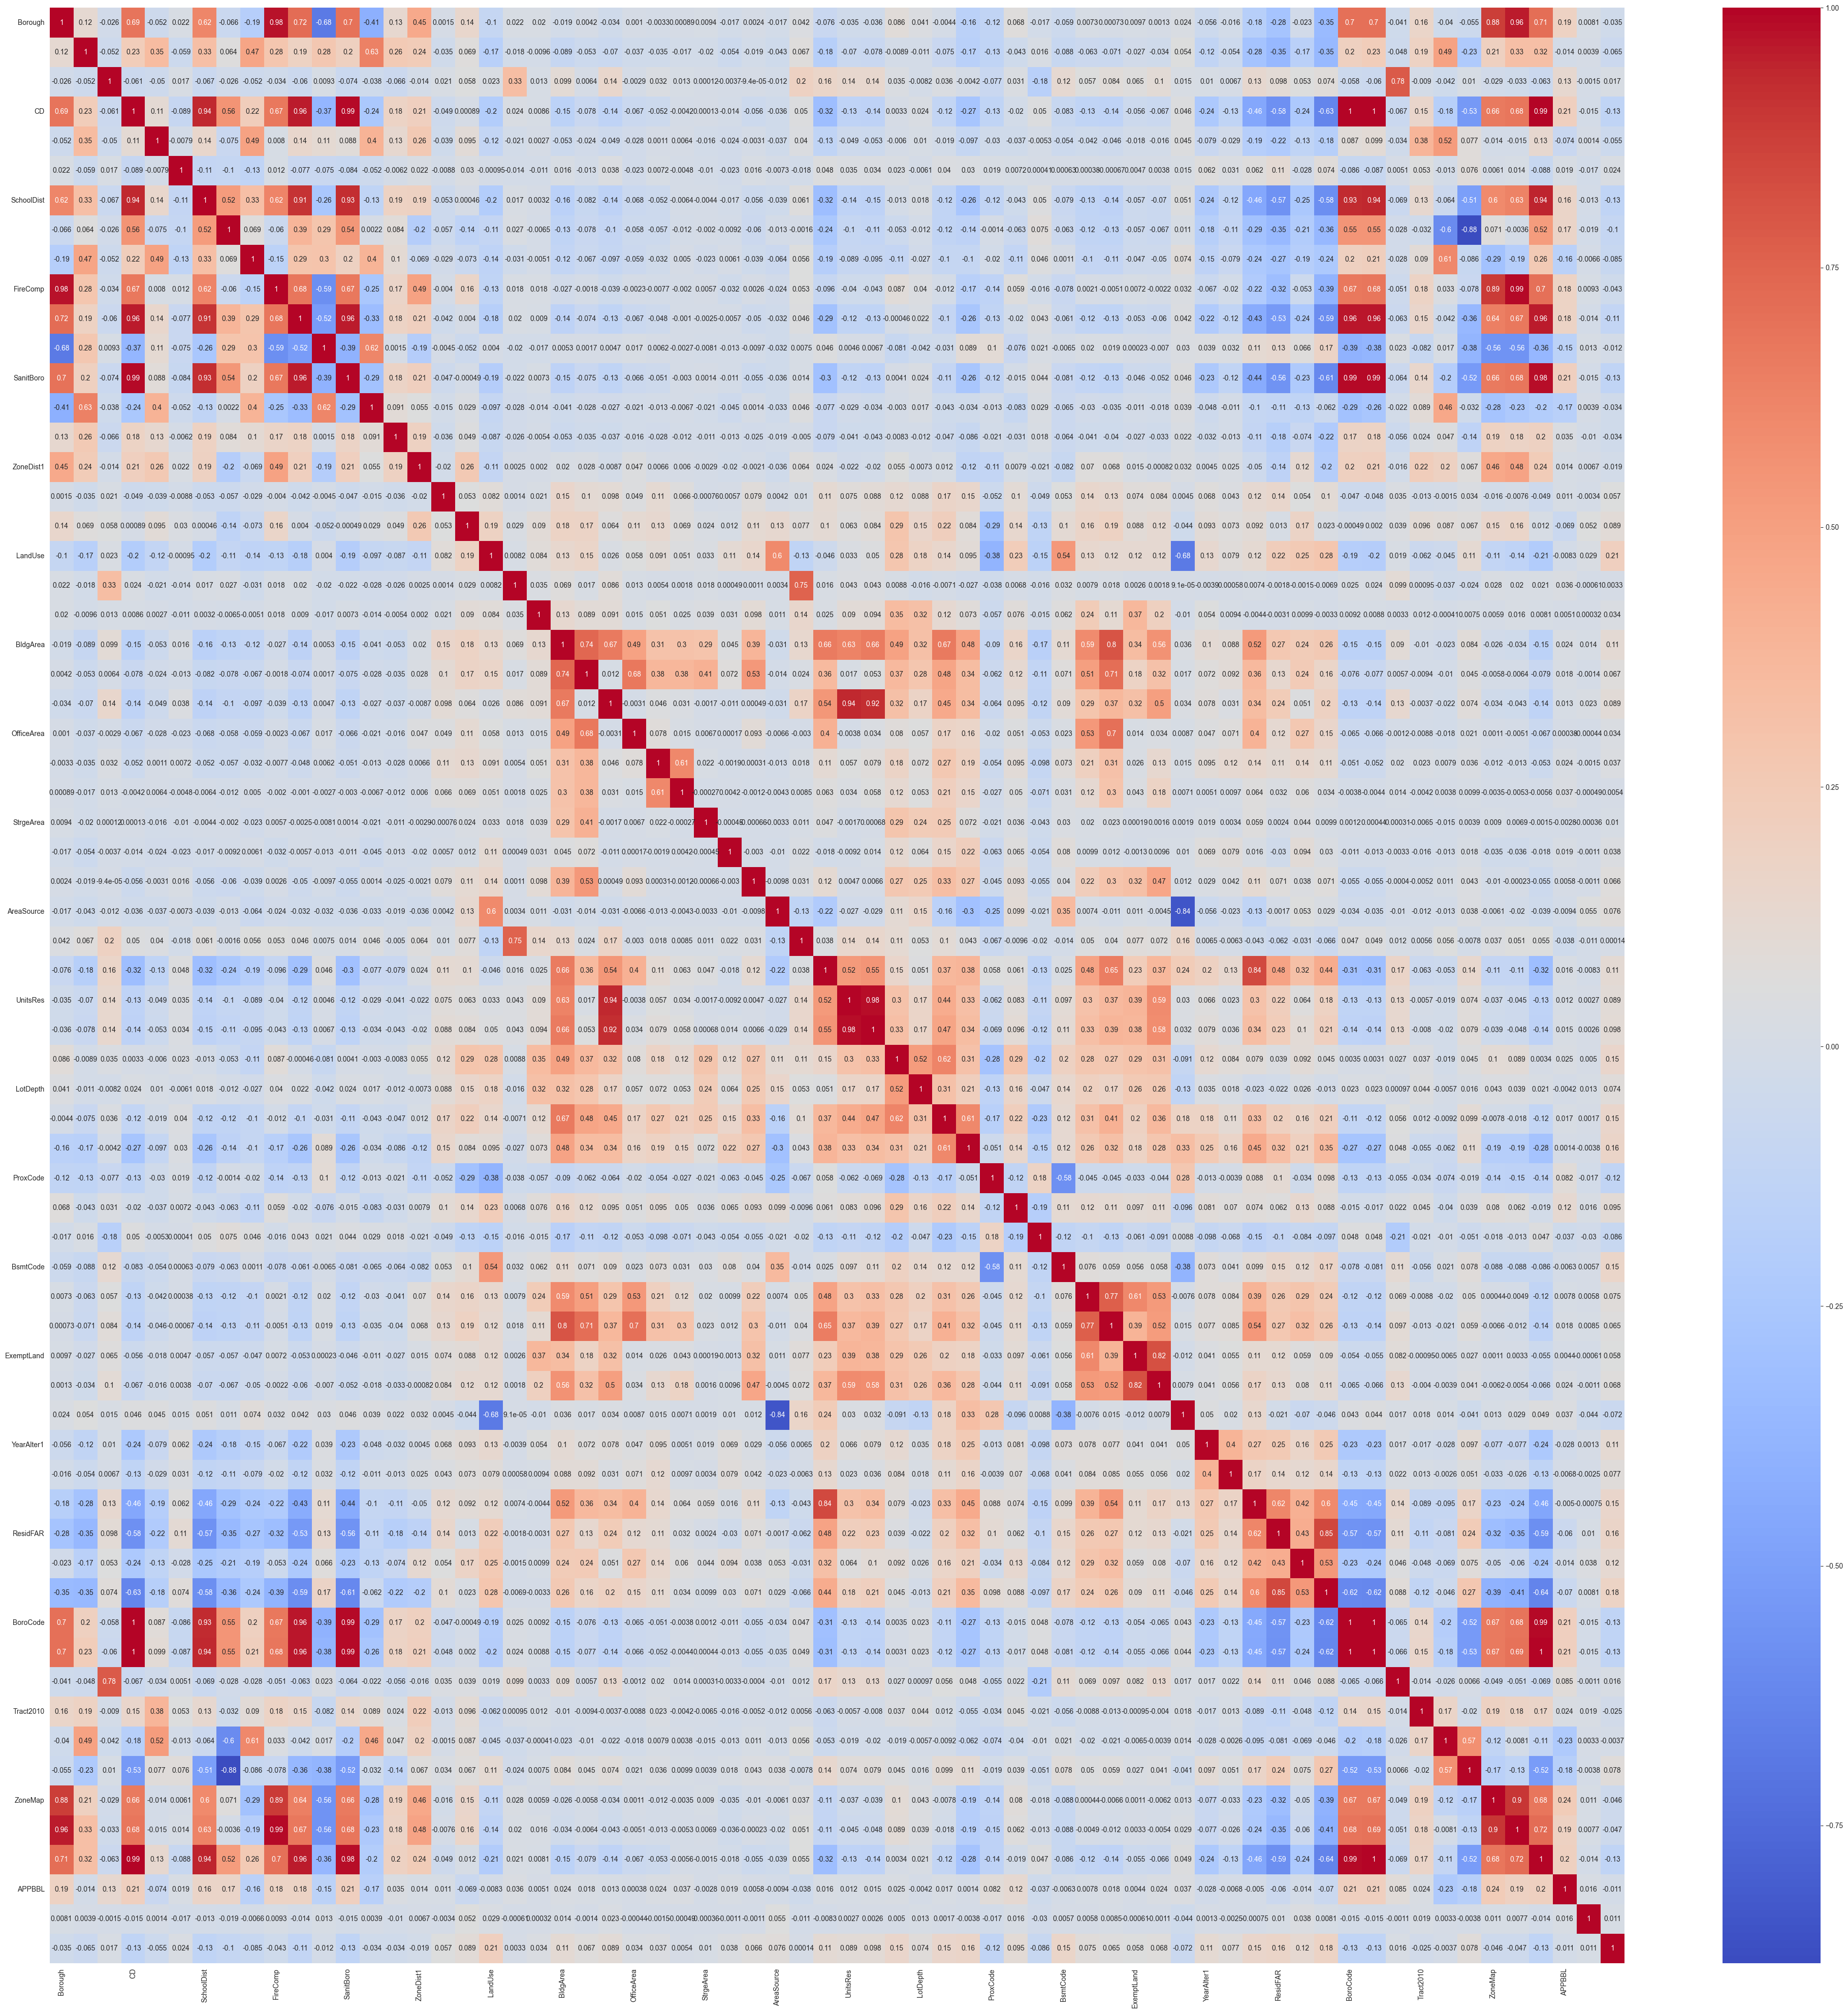

In [175]:
# sns.heatmap(df[[item for item in list(df.columns) if item not in ['Address', 'OwnerName']]].corr(), annot=True, cmap='coolwarm')
# fig = plt.gcf()
# fig.set_size_inches(50, 50)
# plt.show()

## Train-test-split

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
X, Y = df.drop(['Borough'], axis=1), df['Borough']
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

## PCA

In [224]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [225]:
from sklearn.decomposition import PCA
pca = PCA(0.8)
train_X_pca = pca.fit_transform(train_X_scaled)
test_X_pca = pca.transform(test_X_scaled)
train_X_pca

array([[ 2.22826239, -1.57043211,  1.30777269, ...,  0.07682101,
        -0.08382071, -0.00886127],
       [ 2.03588389, -1.62331024, -0.09512721, ...,  0.21288986,
         0.33951406, -0.08286241],
       [ 3.85545972, -2.02950143, -0.95384801, ..., -0.12519825,
        -0.06044291,  0.5464139 ],
       ...,
       [-0.21815318,  3.0317344 ,  0.53383659, ..., -2.32057586,
         1.50007582, -0.50317991],
       [ 1.65976452, -1.17460844, -0.17610629, ..., -0.13618936,
         0.02356597, -0.55478268],
       [-4.10094443,  1.88969485, -2.59527743, ..., -0.04866369,
        -0.10845629,  1.06243075]])

In [226]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1,
                                                         round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            list(range(24)))))

1 component: 18.12% of initial variance
-0.099 x 0 + 0.034 x 1 + -0.267 x 2 + -0.050 x 3 + 0.021 x 4 + -0.255 x 5 + -0.138 x 6 + -0.071 x 7 + -0.189 x 8 + -0.257 x 9 + 0.103 x 10 + -0.263 x 11 + 0.036 x 12 + -0.067 x 13 + -0.073 x 14 + 0.028 x 15 + -0.010 x 16 + 0.084 x 17 + 0.008 x 18 + 0.045 x 19 + 0.133 x 20 + 0.102 x 21 + 0.090 x 22 + 0.087 x 23
2 component: 11.04% of initial variance
0.006 x 0 + 0.021 x 1 + 0.123 x 2 + -0.020 x 3 + -0.008 x 4 + 0.107 x 5 + 0.018 x 6 + -0.051 x 7 + 0.158 x 8 + 0.121 x 9 + -0.100 x 10 + 0.126 x 11 + -0.087 x 12 + 0.021 x 13 + 0.078 x 14 + 0.026 x 15 + 0.116 x 16 + 0.031 x 17 + 0.040 x 18 + 0.178 x 19 + 0.300 x 20 + 0.292 x 21 + 0.105 x 22 + 0.226 x 23
3 component: 5.91% of initial variance
0.307 x 0 + -0.067 x 1 + -0.032 x 2 + 0.282 x 3 + -0.050 x 4 + 0.024 x 5 + 0.014 x 6 + 0.339 x 7 + -0.124 x 8 + -0.041 x 9 + 0.251 x 10 + -0.052 x 11 + 0.372 x 12 + 0.081 x 13 + 0.013 x 14 + -0.037 x 15 + -0.017 x 16 + -0.139 x 17 + 0.002 x 18 + 0.141 x 19 + 0.074

## Visualization

Projecting 65-dimensional data to 2D


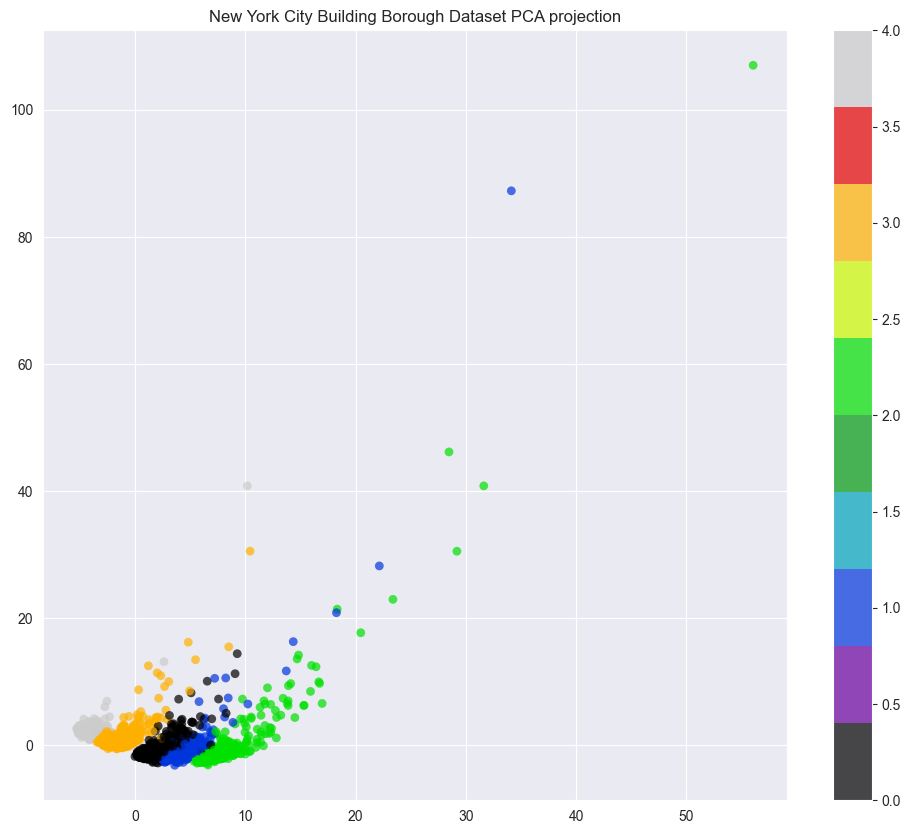

In [227]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train_X_scaled)

print('Projecting %d-dimensional data to 2D' % train_X_scaled.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_Y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('New York City Building Borough Dataset PCA projection');

### Analysis

The PCA grouped all the objects into six large group. On that image we can see that they are separate, but still they are faintly distinguishable.

## TSNE

CPU times: total: 4min 19s
Wall time: 49.1 s


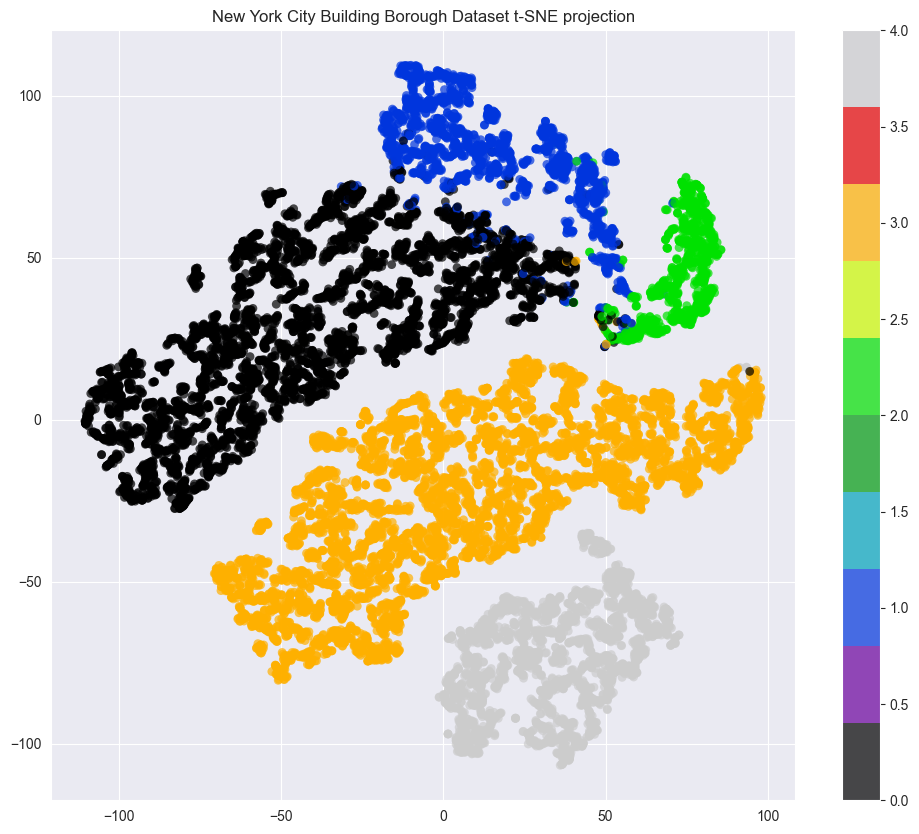

In [165]:
%%time

from sklearn.manifold import TSNE

pca = PCA(n_components=5)
X_reduced = pca.fit_transform(test_X_scaled)

tsne = TSNE(random_state=42)

X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=test_Y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("New York City Building Borough Dataset t-SNE projection");

### Analysis

TSNE conducted the grouping much better, however, some individual parts sometimes get mixed up.

## Complex feature analysis

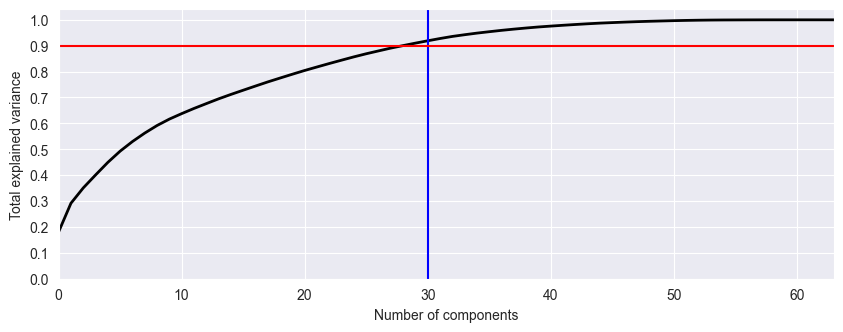

In [228]:
pca = PCA().fit(train_X_scaled)

plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.9, c='r')
plt.show();

According to the graph, 20 feature describe around 80% of the variance, 30 - more than 90%, and 45 describe almost 100%. This suggests that the dimension of the dataset can be reduced without significantly impairing the clustering results.

# Models Estimation

## Metrics

The dataset contains unambiguous answers for all data, so they will be used 'homogeneity_score', 'completeness_score', 'rand_score',
             'f1_score', 'accuracy_score', 'precision_score', 'recall_score'

In [273]:
results = pd.DataFrame(
    columns=['ensemble_name', 'homogeneity_score', 'completeness_score', 'rand_score',
             'f1_score', 'accuracy_score', 'precision_score', 'recall_score'])

## Data

In [ ]:
# X, Y = df.drop(['Borough'], axis=1), df['Borough']
# train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [230]:
xs_train = [train_X, *(PCA(n_components=c).fit_transform(train_X) for c in [20, 30, 45])]
xs_test = [test_X, *(PCA(n_components=c).fit_transform(test_X) for c in [20, 30, 45])]

## Helper functions

In [231]:
def get_valid_prediction(target, labels):
    from collections import Counter

    res = pd.DataFrame()
    res['target'] = target
    res['label'] = labels

    most_commons = []
    for cluster_label in np.unique(labels):
        most_commons += list(map(lambda x: (cluster_label, *x), Counter(res[res['label'] == cluster_label]['target']).most_common(5)))

    most_commons.sort(key=lambda x: (x[2]), reverse=True)
    # print(most_commons)

    cluster_to_borough_map = {}
    for elem in most_commons:
        if elem[0] not in cluster_to_borough_map.keys():
            cluster_to_borough_map[elem[0]] = elem[1]

    predictions = [cluster_to_borough_map[label] for label in labels]
    res['label'] = predictions

    return res, cluster_to_borough_map, predictions

In [232]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, rand_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def estimate_model(name, model, grid: GridSearchCV, train_X, train_Y, test_X, test_Y, df, fit_predict=False):
    res = {'ensemble_name': name}

    grid.fit(train_X)
    best_params = grid.best_params_

    start_time = datetime.now()
    model = model.set_params(**best_params)
    model.fit(train_X)
    end_time = datetime.now()
    res['training_time'] = end_time - start_time

    _, cluster_to_borough_map, y_pred = get_valid_prediction(train_Y, model.labels_)
    # _, _, y_pred = get_valid_prediction(test_Y, model.predict(test_X), cluster_to_borough_map)
    if not fit_predict:
        y_pred = [cluster_to_borough_map[label] for label in model.predict(test_X)]
        test = test_Y
    else:
        test = train_Y
    
    
    print("Start scoring...")
    # test_Y = pd.DataFrame(test_Y)
    # res['silhouette_score'] = silhouette_score(pd.DataFrame(test_Y), y_pred)
    # print(res['silhouette_score'])
    res['homogeneity_score'] = homogeneity_score(test, y_pred)
    # print(res['homogeneity_score'])
    res['completeness_score'] = completeness_score(test, y_pred)
    # print(res['completeness_score'])
    res['rand_score'] = rand_score(test, y_pred)
    # print(res['rand_score'])

    res['f1_score'] = f1_score(test, y_pred, average='weighted')
    # print(res['f1_score'])
    res['accuracy_score'] = accuracy_score(test, y_pred)
    # print(res['accuracy_score'])
    res['precision_score'] = precision_score(test, y_pred, average='weighted')
    # print(res['precision_score'])
    res['recall_score'] = recall_score(test, y_pred, average='weighted')
    # print(res['recall_score'])

    cm = confusion_matrix(test, y_pred)
    # print(cm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 'fmt='d' displays values as integers
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return grid, model, pd.concat([df, pd.DataFrame(res, index=[0])])

## Sklearn KMeans

In [274]:
param_grid = {
    'n_clusters': [10, 12, 15], # 
    'init': ['random', 'k-means++'], #  
    'max_iter': [100, 200] # 
}

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

kmeans = KMeans()
grid_search = GridSearchCV(kmeans, param_grid, scoring='rand_score', cv=3, n_jobs=-1)

Start scoring...


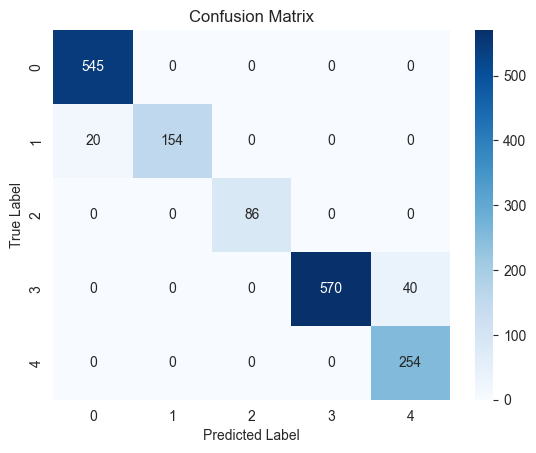

Start scoring...


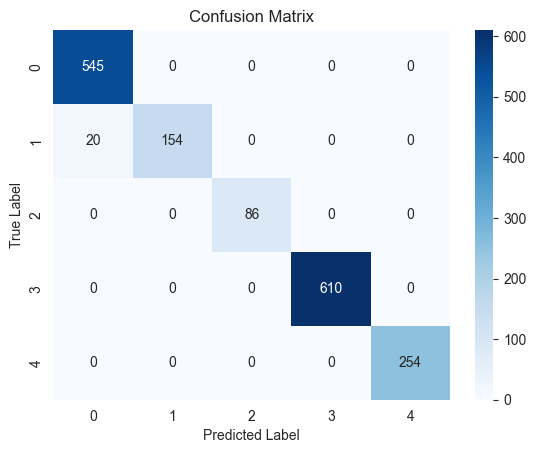

Start scoring...


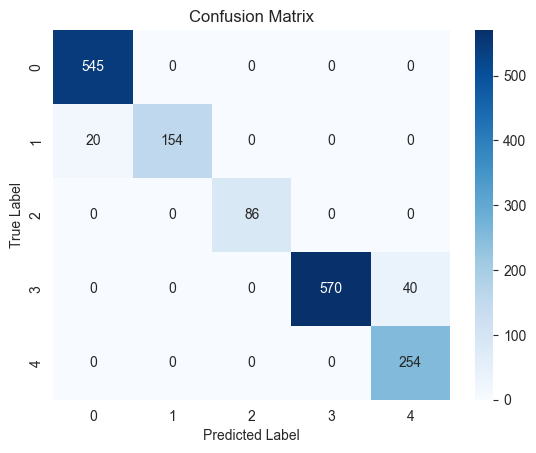

Start scoring...


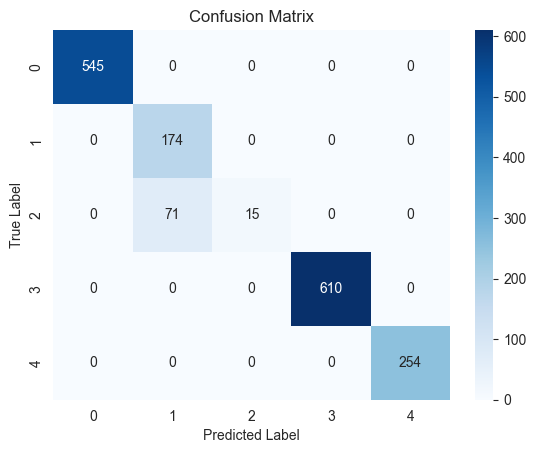

In [275]:
for _x_train, _x_test, pca_c in zip(xs_train, xs_test, [0, 20, 30, 40]):
    _, _, results = estimate_model(f"KMeansSklearnPCA={pca_c}", kmeans, grid_search, _x_train, train_Y, _x_test, test_Y, results)

In [276]:
results

,ensemble_name,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score,training_time
0,KMeansSklearnPCA=0,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.065999
0,KMeansSklearnPCA=20,0.963216,0.973317,0.989957,0.987759,0.988017,0.988441,0.988017,0 days 00:00:00.027000
0,KMeansSklearnPCA=30,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.027000
0,KMeansSklearnPCA=40,0.937257,0.982254,0.990360,0.946111,0.957460,0.969788,0.957460,0 days 00:00:00.201320


## MyKMeans Realization

## Work too slow, but clusterize correct

In [190]:
import numpy as np
from typing import Tuple, Dict


class MyKMeansFromScratch: 
    """
    Class to encapsulate the K-Means algorithm
    """

    def __init__(self, n_clusters: int = 3, n_init: int = 3, max_iters: int = 100) -> None:
        """
        Initializer function for a class instance

        Inputs:
            K            -> integer number of clusters to assign
            n_init       -> integer number of times the algorithm will be applied when training
            max_iters    -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if n_clusters <= 0:
            raise ValueError(f'K must be a positive integer, got: {n_clusters}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.cluster_centers_ = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters
        self.labels_ = np.array([])

    @staticmethod
    def __assign_samples(X: np.array, centroids: np.array) -> np.array:
        """
        Private function to assign samples to clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:, np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    @staticmethod
    def __partition_data(X: np.array, cluster_assignment: np.array) -> list:
        """
        Private function to partition input features according to cluster assignment

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
        Output:
            list of numpy arrays of centroid for cluster, each array with shape:
            [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1, 1)), axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:, :-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X: np.array, cluster_assignment: np.array,
                       centroids: np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i, :],
                                         X_clusters[i] - centroids[i, :]) for i in range(self.n_clusters)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)

    def __update_centroids(self, X: np.array, cluster_assignment: np.array) -> np.array:
        """
        Private function to update cluster centroids

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluser assignments with shape: [number_samples,]
        Output:
            numpy array of centroids with shape: [K, number_features]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def fit(self, X: np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS

        Inputs:
            X -> numpy array of input features of assumed  shape [number_samples, number_features]
        Output:
            MyKMeans -> K-means clustering
        """
        # initialise wcss score
        self.total_wcss = np.inf

        # loop over all iterations requested
        for i in range(self.n_init):
            # initialise centroids
            centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.n_clusters))
            iteration = 0
            while (not np.array_equal(centroid_diff, np.zeros(self.n_clusters))) and iteration < self.max_iters:
                # assign samples to clusters
                self.labels_ = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, self.labels_)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration += 1
                old_centroids = np.copy(centroids)

            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, self.labels_, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.cluster_centers_ = centroids

            print(f"Loop iter {i}")

        return self

    def predict(self, X: np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids

        Input:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.cluster_centers_.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.cluster_centers_)

    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)

        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.cluster_centers_.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.total_wcss, self.wcss_array

    def get_params(self, deep: bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'n_clusters': self.n_clusters,
                'n_init': self.n_init,
                'max_iters': self.max_iters}

    def set_params(self, **params):
        """
        Public function to set model parameters
        Inputs:
            Dict -> dictionary of stored class input parameters
        Outputs:
            KMeans obj
        """
        if not params:
            return self

        valid_params = self.get_params(deep=True)
        for key, value in params.items():
            if key in valid_params:
                setattr(self, key, value)

        return self

    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.n_clusters
        del self.n_init
        del self.cluster_centers_
        del self.total_wcss
        del self.wcss_array
        del self.max_iters

### Another K-Means Realization Usage Base Cluster Methods

In [269]:
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, ClusterMixin


class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        max_center_shift = np.inf
        x = check_array(x)
        self.n_features_in_ = x.shape[1]
        self.random_state_ = check_random_state(self.random_state)

        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1) 
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        
        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))
            
            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

In [277]:
param_grid = {
    'n_clusters': [10, 5], # , 12, 15 
    'tol': [0.01] # 
}

from sklearn.model_selection import GridSearchCV

kmeans_my = MyKMeans(random_state=0)
grid_search = GridSearchCV(kmeans_my, param_grid, scoring='rand_score', cv=3) # , n_jobs=-1

Start scoring...


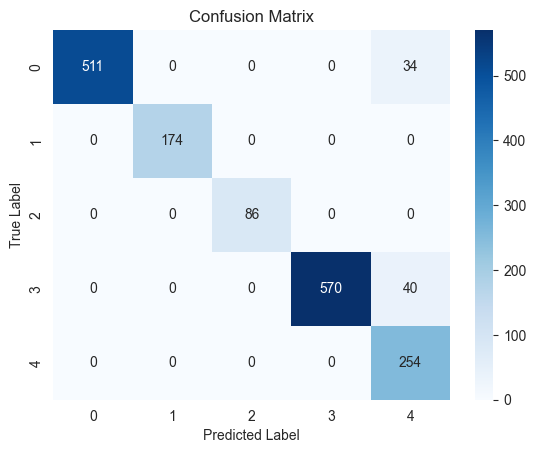

Start scoring...


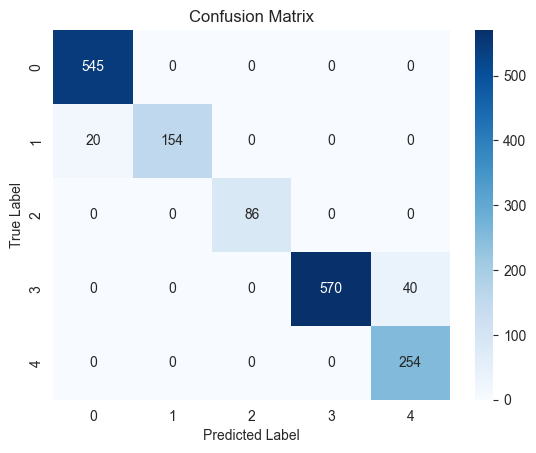

Start scoring...


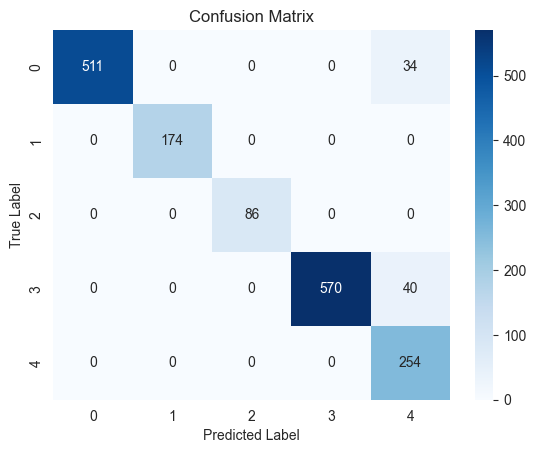

Start scoring...


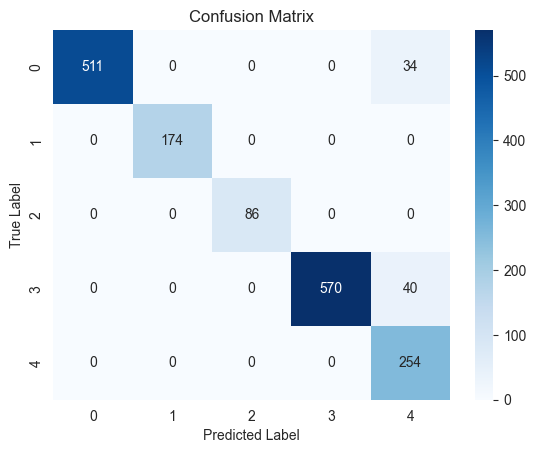

In [278]:
for _x_train, _x_test, pca_c in zip(xs_train, xs_test, [0, 20, 30, 40]):
    _, _, results = estimate_model(f"MyKMeansPCA={pca_c}", kmeans_my, grid_search, _x_train, train_Y, _x_test, test_Y,
                                   results, fit_predict=False)

In [279]:
results

,ensemble_name,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score,training_time
0,KMeansSklearnPCA=0,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.065999
0,KMeansSklearnPCA=20,0.963216,0.973317,0.989957,0.987759,0.988017,0.988441,0.988017,0 days 00:00:00.027000
0,KMeansSklearnPCA=30,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.027000
0,KMeansSklearnPCA=40,0.937257,0.982254,0.990360,0.946111,0.957460,0.969788,0.957460,0 days 00:00:00.201320
0,MyKMeansPCA=0,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.502769
0,MyKMeansPCA=20,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.209802
0,MyKMeansPCA=30,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.380520
0,MyKMeansPCA=40,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.397958


## Agglomerative Clustering

In [280]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_clusters': [5], 
    'metric': ["euclidean"],
    'compute_full_tree': ["auto", False],
    'linkage': ["complete", "ward", "average", "single"] # 
}

agg = AgglomerativeClustering()
grid_search = GridSearchCV(agg, param_grid, scoring='rand_score', cv=3, n_jobs=-1)

Start scoring...


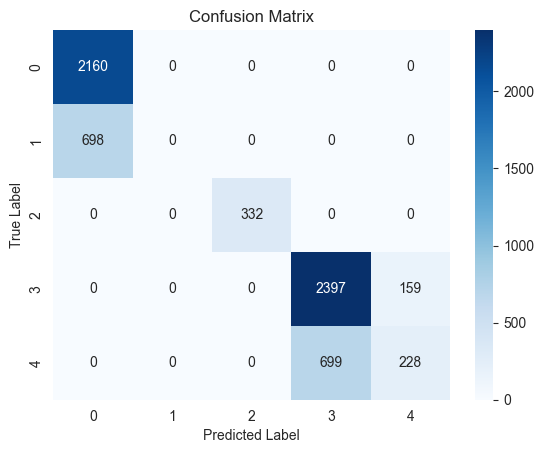

Start scoring...


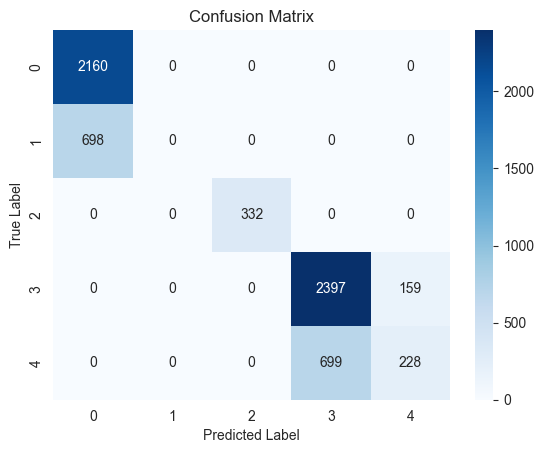

Start scoring...


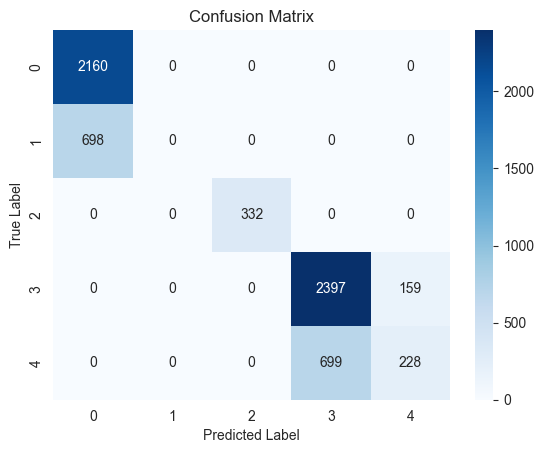

Start scoring...


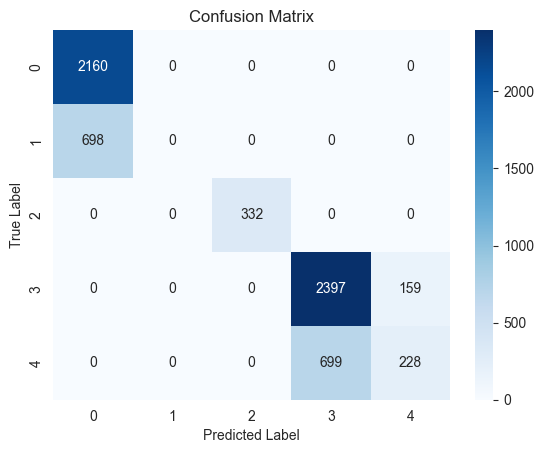

In [281]:
for _x_train, _x_test, pca_c in zip(xs_train, xs_test, [0, 20, 30, 40]):
    _, _, results = estimate_model(f'AffinityPropagation_PCAP={pca_c}', agg, grid_search, _x_train, train_Y, _x_test, test_Y, results, fit_predict=True)

In [282]:
results

,ensemble_name,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score,training_time
0,KMeansSklearnPCA=0,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.065999
0,KMeansSklearnPCA=20,0.963216,0.973317,0.989957,0.987759,0.988017,0.988441,0.988017,0 days 00:00:00.027000
0,KMeansSklearnPCA=30,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.027000
0,KMeansSklearnPCA=40,0.937257,0.982254,0.990360,0.946111,0.957460,0.969788,0.957460,0 days 00:00:00.201320
0,MyKMeansPCA=0,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.502769
0,MyKMeansPCA=20,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.209802
0,MyKMeansPCA=30,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.380520
0,MyKMeansPCA=40,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.397958
0,AffinityPropagation_PCAP=0,0.622811,0.838726,0.831099,0.701518,0.766822,0.672790,0.766822,0 days 00:00:01.021388
0,AffinityPropagation_PCAP=20,0.622811,0.838726,0.831099,0.701518,0.766822,0.672790,0.766822,0 days 00:00:00.753846


 ## DBSCAN

In [283]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

param_grid = {
    'eps': [1, 0.5, 2],
    'min_samples': [1], 
    'algorithm': ['kd_tree', 'auto'],
    'leaf_size': [30, 50], 
    'metric': ['euclidean'],
    'p': [None],
}

dbscan = DBSCAN()
grid_search = GridSearchCV(dbscan, param_grid, scoring='rand_score', cv=3, n_jobs=-1)

Start scoring...


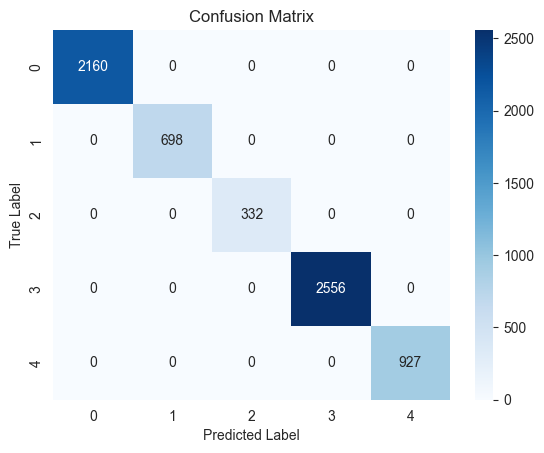

Start scoring...


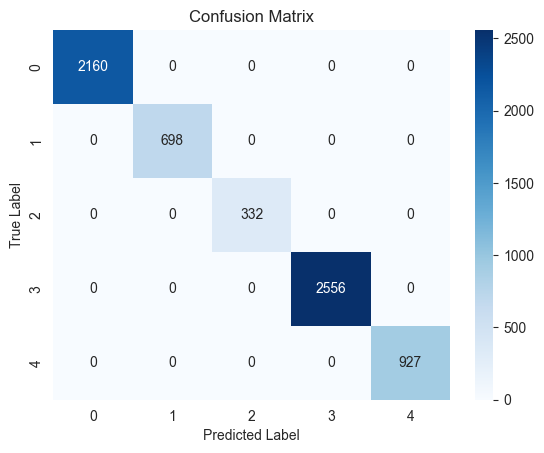

Start scoring...


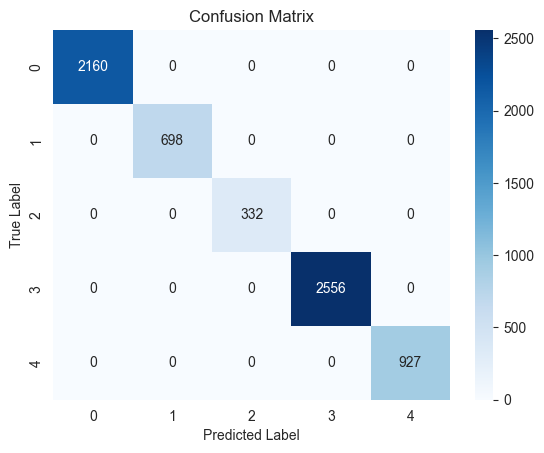

Start scoring...


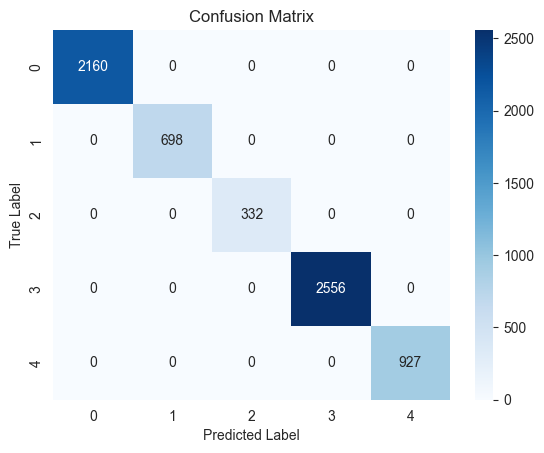

In [284]:
for _x_train, _x_test, pca_c in zip(xs_train, xs_test, [0, 20, 30, 40]):
    dbscan_sklearn_grid, dbscan_sklearn_model, results = estimate_model(f'DBSCAN_PCAP={pca_c}', dbscan, grid_search, _x_train, train_Y, _x_test, test_Y, results, fit_predict=True)

In [285]:
results

,ensemble_name,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score,training_time
0,KMeansSklearnPCA=0,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.065999
0,KMeansSklearnPCA=20,0.963216,0.973317,0.989957,0.987759,0.988017,0.988441,0.988017,0 days 00:00:00.027000
0,KMeansSklearnPCA=30,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.027000
0,KMeansSklearnPCA=40,0.937257,0.982254,0.990360,0.946111,0.957460,0.969788,0.957460,0 days 00:00:00.201320
0,MyKMeansPCA=0,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.502769
0,MyKMeansPCA=20,0.913469,0.911022,0.966277,0.964261,0.964050,0.967735,0.964050,0 days 00:00:00.209802
0,MyKMeansPCA=30,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.380520
0,MyKMeansPCA=40,0.903779,0.885429,0.956658,0.957747,0.955662,0.965665,0.955662,0 days 00:00:00.397958
0,AffinityPropagation_PCAP=0,0.622811,0.838726,0.831099,0.701518,0.766822,0.672790,0.766822,0 days 00:00:01.021388
0,AffinityPropagation_PCAP=20,0.622811,0.838726,0.831099,0.701518,0.766822,0.672790,0.766822,0 days 00:00:00.753846


# Results

Reducing the dimension of the data had not a significant impact on the learning time, but if we had more features it can be changed? for example, exponentially. At the same time, the quality of the results also changed very slightly.

- The MyKMeans algorithm need more time, since it does not have parallelism and optimizations.

- The AffinityPropagation algorithm worked the longest and the KMeans, obviously, turned out to be the most efficient than DBSCAN.

- Qualitatively, DBSCAN algorithm have the best results and can clasterize presented data ideally correct.